# Import libraries and load two raw dataframes

In [672]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.stats import chi2
from scipy.stats import chi2_contingency
np.random.seed(10)

# Load the date in timedate format
price_demand = pd.read_csv('price_demand_data.csv', parse_dates=['SETTLEMENTDATE'], dayfirst=True)
weather = pd.read_csv('weather_data.csv', parse_dates=['Date'], dayfirst=True)
display(price_demand)
display(weather)

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
0,VIC1,2021-01-01 00:30:00,4179.21,LOW
1,VIC1,2021-01-01 01:00:00,4047.76,LOW
2,VIC1,2021-01-01 01:30:00,3934.70,LOW
3,VIC1,2021-01-01 02:00:00,3766.45,LOW
4,VIC1,2021-01-01 02:30:00,3590.37,LOW
...,...,...,...,...
11659,VIC1,2021-08-31 22:00:00,4861.91,MEDIUM
11660,VIC1,2021-08-31 22:30:00,4748.74,MEDIUM
11661,VIC1,2021-08-31 23:00:00,4620.09,MEDIUM
11662,VIC1,2021-08-31 23:30:00,4834.00,MEDIUM


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-01-01,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2021-01-02,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,2021-01-03,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,2021-01-04,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,2021-01-05,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2021-08-27,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,7.7,...,7,,Calm,1020.0,12.8,65,7.0,SSE,7,1017.4
239,2021-08-28,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,9.1,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
240,2021-08-29,9.1,16.2,0.6,6.4,4.3,NNE,33.0,1:50,10.6,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4
241,2021-08-30,6.4,17.6,4.0,1.4,7.4,NNW,50.0,14:04,11.1,...,7,N,15,1016.1,16.8,45,1.0,NNW,28,1013.2


# Data preparation

### Data mining

In [674]:
# Replace PRICECATEGORY values with Numeric values in new column PRICE_NUMERIC
price_demand['PRICECATEGORY'].replace( {'LOW' : 0, 'MEDIUM' : 1, 'HIGH' : 2, 'EXTREME': 3 }, inplace=True)

# Extract Date and Time seperately from SETTLEMENTDATE in date time format
price_demand['Date'] = pd.to_datetime(price_demand['SETTLEMENTDATE'].dt.date)
price_demand['Time'] = price_demand['SETTLEMENTDATE'].dt.time

# Due to the special definition of a day in raw dataset, a day invloving two dates. 
# Each ordinal day involves every 48 rows of 30-minute time slots
price_demand['Ordinal_Day'] = price_demand.index // 48

#### Extracting the maximum daily energy usage

In [675]:
demand = price_demand

max_demand = demand.groupby('Ordinal_Day')['TOTALDEMAND'].transform(max) == demand['TOTALDEMAND']
max_demand = demand[max_demand].reset_index()
max_demand['TOTALDEMAND_MAX'] = max_demand['TOTALDEMAND']
max_demand = max_demand.drop(columns=['index','REGION','SETTLEMENTDATE','TOTALDEMAND','PRICECATEGORY'])
max_demand

,Date,Time,Ordinal_Day,TOTALDEMAND_MAX
0,2021-01-01,17:30:00,0,5019.64
1,2021-01-02,17:00:00,1,4964.35
2,2021-01-03,18:30:00,2,4503.31
3,2021-01-04,18:30:00,3,4764.18
4,2021-01-05,17:00:00,4,4800.64
...,...,...,...,...
238,2021-08-27,19:00:00,238,6769.89
239,2021-08-28,19:00:00,239,5716.32
240,2021-08-29,19:00:00,240,6227.89
241,2021-08-30,18:30:00,241,6072.91


#### Extracting the maximum daily price category

In [676]:
price = price_demand

# Have to group by ordinal day, otherwise the first day of following month will show up.
max_price = price.groupby('Ordinal_Day')['PRICECATEGORY'].max()
max_price = max_price.reset_index()
max_price['PRICE_NUMERIC_MAX'] = max_price['PRICECATEGORY']
max_price = max_price.drop(columns = ['PRICECATEGORY'])

max_price

,Ordinal_Day,PRICE_NUMERIC_MAX
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
238,238,3
239,239,1
240,240,3
241,241,2


# Merge all datasets

In [677]:
weather.set_index('Date')
max_demand.set_index('Ordinal_Day')
max_price.set_index('Ordinal_Day')

max_price_demand = pd.merge(max_demand, max_price, how='outer', on='Ordinal_Day')
all_dataset = pd.merge(max_price_demand,weather, how='outer', on='Date')

In [678]:
dataset = all_dataset[['Date','Ordinal_Day','TOTALDEMAND_MAX', 'PRICE_NUMERIC_MAX',\
                    'Minimum temperature (°C)', 'Maximum temperature (°C)',\
                    '3pm MSL pressure (hPa)', '3pm Temperature (°C)', '3pm cloud amount (oktas)', '3pm relative humidity (%)', '3pm wind speed (km/h)', \
                    '9am MSL pressure (hPa)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am relative humidity (%)', '9am wind speed (km/h)', \
                    'Evaporation (mm)', 'Rainfall (mm)', 'Speed of maximum wind gust (km/h)','Sunshine (hours)']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               243 non-null    datetime64[ns]
 1   Ordinal_Day                        243 non-null    int64         
 2   TOTALDEMAND_MAX                    243 non-null    float64       
 3   PRICE_NUMERIC_MAX                  243 non-null    int64         
 4   Minimum temperature (°C)           242 non-null    float64       
 5   Maximum temperature (°C)           242 non-null    float64       
 6   3pm MSL pressure (hPa)             242 non-null    float64       
 7   3pm Temperature (°C)               243 non-null    float64       
 8   3pm cloud amount (oktas)           242 non-null    float64       
 9   3pm relative humidity (%)          243 non-null    int64         
 10  3pm wind speed (km/h)              243

### Data Cleaning

In [679]:
# DATA imputation: convert 'Calm' to 0 for wind speed columns
dataset = dataset.replace(to_replace='Calm', value=0)

# Convert object to float for certain columns
dataset['9am wind speed (km/h)'] = dataset['9am wind speed (km/h)'].astype(np.float64)
dataset['3pm wind speed (km/h)'] = dataset['3pm wind speed (km/h)'].astype(np.float64)

# Fill null with mean value for numeric cells
dataset = dataset.fillna(round(dataset.mean(),1))

C:\Users\lhong\AppData\Local\Temp\ipykernel_40144\1972671464.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dataset = dataset.fillna(round(dataset.mean(),1))


In [680]:
# check any null value
dataset.isna().sum()

Date                                 0
Ordinal_Day                          0
TOTALDEMAND_MAX                      0
PRICE_NUMERIC_MAX                    0
Minimum temperature (°C)             0
Maximum temperature (°C)             0
3pm MSL pressure (hPa)               0
3pm Temperature (°C)                 0
3pm cloud amount (oktas)             0
3pm relative humidity (%)            0
3pm wind speed (km/h)                0
9am MSL pressure (hPa)               0
9am Temperature (°C)                 0
9am cloud amount (oktas)             0
9am relative humidity (%)            0
9am wind speed (km/h)                0
Evaporation (mm)                     0
Rainfall (mm)                        0
Speed of maximum wind gust (km/h)    0
Sunshine (hours)                     0
dtype: int64

In [633]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               243 non-null    datetime64[ns]
 1   Ordinal_Day                        243 non-null    int64         
 2   TOTALDEMAND_MAX                    243 non-null    float64       
 3   PRICE_NUMERIC_MAX                  243 non-null    int64         
 4   Minimum temperature (°C)           243 non-null    float64       
 5   Maximum temperature (°C)           243 non-null    float64       
 6   3pm MSL pressure (hPa)             243 non-null    float64       
 7   3pm Temperature (°C)               243 non-null    float64       
 8   3pm cloud amount (oktas)           243 non-null    float64       
 9   3pm relative humidity (%)          243 non-null    int64         
 10  3pm wind speed (km/h)              243

In [634]:
dataset.to_csv('dataset.csv',index=False)
dataset.head()

,Date,Ordinal_Day,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),3pm MSL pressure (hPa),3pm Temperature (°C),3pm cloud amount (oktas),3pm relative humidity (%),3pm wind speed (km/h),9am MSL pressure (hPa),9am Temperature (°C),9am cloud amount (oktas),9am relative humidity (%),9am wind speed (km/h),Evaporation (mm),Rainfall (mm),Speed of maximum wind gust (km/h),Sunshine (hours)
0,2021-01-01,0,5019.64,0,15.6,29.9,1015.3,28.1,5.0,43,13.0,1018.8,19.2,6,77.0,2.0,2.8,0.0,31.0,9.3
1,2021-01-02,1,4964.35,0,18.4,29.0,1008.5,28.7,7.0,38,4.0,1013.3,23.3,7,52.0,17.0,9.4,0.0,30.0,1.3
2,2021-01-03,2,4503.31,0,17.0,26.2,1005.2,23.5,4.0,59,2.0,1007.7,18.3,8,100.0,4.0,4.8,12.6,33.0,7.1
3,2021-01-04,3,4764.18,0,16.0,18.6,1011.0,18.2,8.0,82,17.0,1010.0,16.2,8,98.0,11.0,3.8,2.6,41.0,0.0
4,2021-01-05,4,4800.64,0,15.9,19.1,1013.3,18.2,8.0,82,19.0,1012.5,17.2,8,96.0,13.0,1.0,11.2,35.0,0.0


# Data Exploration

In [635]:
dataset.describe()

,Ordinal_Day,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),3pm MSL pressure (hPa),3pm Temperature (°C),3pm cloud amount (oktas),3pm relative humidity (%),3pm wind speed (km/h),9am MSL pressure (hPa),9am Temperature (°C),9am cloud amount (oktas),9am relative humidity (%),9am wind speed (km/h),Evaporation (mm),Rainfall (mm),Speed of maximum wind gust (km/h),Sunshine (hours)
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,121.000000,6137.080165,1.596708,11.051029,19.445679,1015.824691,18.040329,5.301646,56.930041,13.139918,1017.740329,13.720576,5.164609,74.454733,9.842798,3.902469,1.576955,34.412346,5.349383
std,70.292247,818.153258,1.064990,3.862239,5.343012,7.420480,4.963547,2.387103,14.017376,6.248055,7.651588,4.297711,2.562778,14.148271,5.226298,2.702141,4.480126,10.841488,3.604902
min,0.000000,4473.050000,0.000000,1.700000,10.600000,989.000000,8.600000,0.000000,21.000000,0.000000,989.700000,3.000000,0.000000,25.000000,0.000000,0.000000,0.000000,15.000000,0.000000
25%,60.500000,5507.765000,1.000000,8.100000,15.500000,1011.000000,14.400000,3.000000,48.000000,9.000000,1012.800000,10.950000,3.000000,65.000000,7.000000,1.900000,0.000000,28.000000,2.150000
50%,121.000000,6234.670000,2.000000,10.900000,18.300000,1015.800000,17.100000,7.000000,56.000000,13.000000,1018.100000,13.400000,7.000000,75.000000,9.000000,3.200000,0.000000,33.000000,4.900000
75%,181.500000,6763.515000,3.000000,13.800000,21.800000,1021.600000,20.150000,7.000000,66.000000,17.000000,1023.600000,16.400000,7.000000,84.000000,13.000000,5.600000,0.800000,41.000000,8.350000
max,242.000000,8196.830000,3.000000,22.200000,39.200000,1032.400000,35.200000,8.000000,98.000000,37.000000,1034.200000,30.900000,8.000000,100.000000,30.000000,13.800000,43.200000,67.000000,13.100000


### Pearson corelation

In [697]:
# Pairwise pearson r correlation matrix between different variables
corr = dataset[['TOTALDEMAND_MAX', 'PRICE_NUMERIC_MAX',\
                    'Minimum temperature (°C)', 'Maximum temperature (°C)',\
                    '3pm MSL pressure (hPa)', '3pm Temperature (°C)', '3pm cloud amount (oktas)', '3pm relative humidity (%)', '3pm wind speed (km/h)', \
                    '9am MSL pressure (hPa)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am relative humidity (%)', '9am wind speed (km/h)', \
                    'Evaporation (mm)', 'Rainfall (mm)', 'Speed of maximum wind gust (km/h)','Sunshine (hours)']].corr(method='pearson')

# corr = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', \
#                 'Evaporation (mm)', 'Sunshine (hours)', 'Speed of maximum wind gust (km/h)' \
#                 ]].corr(method='pearson')
# corr = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Evaporation (mm)', \
#                   '9am Temperature (°C)', '3pm Temperature (°C)' ]].corr(method='pearson')

corr

,TOTALDEMAND_MAX,PRICE_NUMERIC_MAX,Minimum temperature (°C),Maximum temperature (°C),3pm MSL pressure (hPa),3pm Temperature (°C),3pm cloud amount (oktas),3pm relative humidity (%),3pm wind speed (km/h),9am MSL pressure (hPa),9am Temperature (°C),9am cloud amount (oktas),9am relative humidity (%),9am wind speed (km/h),Evaporation (mm),Rainfall (mm),Speed of maximum wind gust (km/h),Sunshine (hours)
TOTALDEMAND_MAX,1.000000,0.689760,-0.489533,-0.289752,-0.002709,-0.324949,0.069170,0.063297,-0.041129,0.055153,-0.391435,-0.168528,0.101348,0.115612,-0.266111,-0.074812,0.080592,-0.137979
PRICE_NUMERIC_MAX,0.689760,1.000000,-0.598147,-0.510314,0.186315,-0.511981,0.077795,0.202660,-0.223119,0.217823,-0.563436,-0.123949,0.331852,-0.031631,-0.487292,0.014153,-0.187746,-0.250420
Minimum temperature (°C),-0.489533,-0.598147,1.000000,0.707525,-0.278096,0.661579,0.062062,-0.055011,-0.022712,-0.326020,0.915726,0.206426,-0.333646,-0.003147,0.655091,0.043350,0.055604,0.081852
Maximum temperature (°C),-0.289752,-0.510314,0.707525,1.000000,-0.178450,0.965177,-0.238622,-0.456635,-0.028451,-0.101658,0.820029,-0.170090,-0.309292,-0.073599,0.620727,-0.124851,-0.056150,0.469026
3pm MSL pressure (hPa),-0.002709,0.186315,-0.278096,-0.178450,1.000000,-0.130976,-0.225539,-0.031038,-0.194540,0.953812,-0.277609,-0.121659,0.138686,-0.260846,-0.254218,-0.056866,-0.426542,0.132126
3pm Temperature (°C),-0.324949,-0.511981,0.661579,0.965177,-0.130976,1.000000,-0.274480,-0.543138,0.006479,-0.039179,0.761603,-0.181595,-0.261369,-0.087414,0.560214,-0.126947,-0.097792,0.487546
3pm cloud amount (oktas),0.069170,0.077795,0.062062,-0.238622,-0.225539,-0.274480,1.000000,0.342132,-0.056507,-0.287912,-0.003270,0.392265,0.031220,0.079501,-0.095794,0.111438,0.135828,-0.722236
3pm relative humidity (%),0.063297,0.202660,-0.055011,-0.456635,-0.031038,-0.543138,0.342132,1.000000,-0.197626,-0.143348,-0.157130,0.424203,0.402234,-0.188580,-0.208511,0.194572,-0.083754,-0.550315
3pm wind speed (km/h),-0.041129,-0.223119,-0.022712,-0.028451,-0.194540,0.006479,-0.056507,-0.197626,1.000000,-0.136046,0.022960,0.002685,-0.231550,0.396611,0.022986,0.047473,0.674301,0.091350
9am MSL pressure (hPa),0.055153,0.217823,-0.326020,-0.101658,0.953812,-0.039179,-0.287912,-0.143348,-0.136046,1.000000,-0.285476,-0.198445,0.142855,-0.253368,-0.272172,-0.138610,-0.414861,0.206701


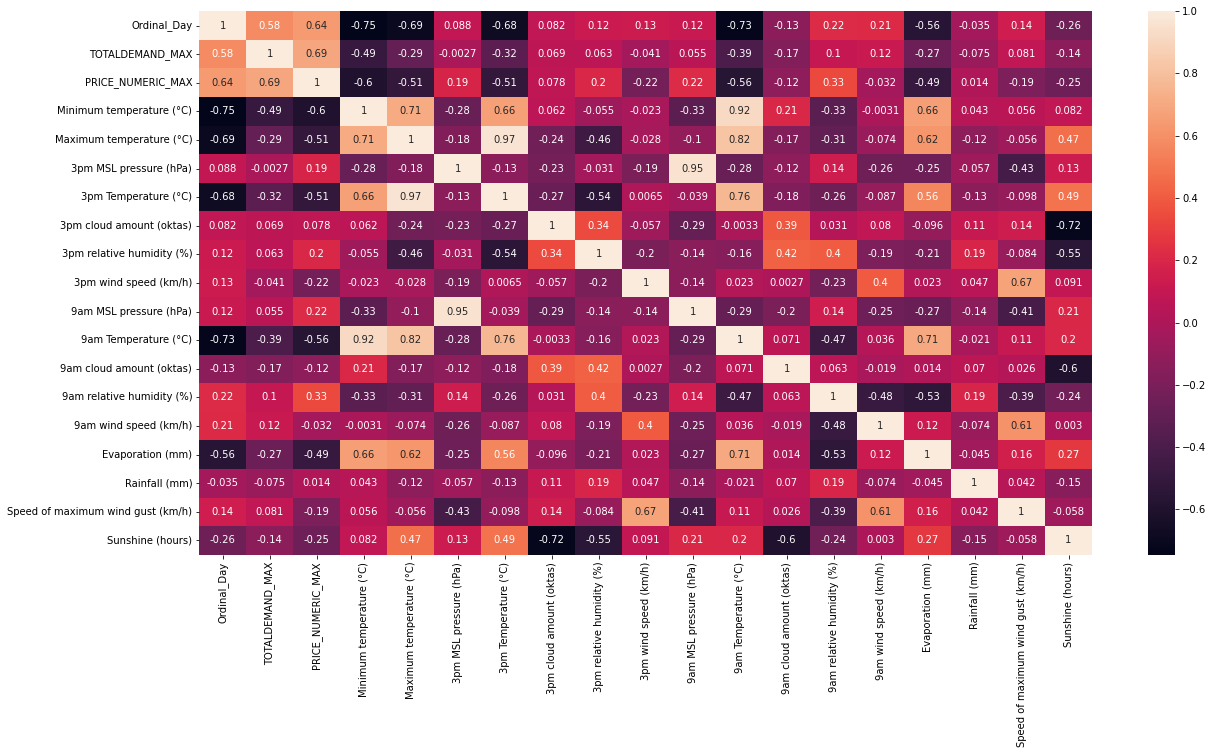

In [698]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset.corr(), annot = True);

### 1st model: Predict max daily energy demand on weather
### LINEAR REGRESSION MODEL

In [787]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model

# Choose the features (input)
X = dataset[['Minimum temperature (°C)', 'Sunshine (hours)','Evaporation (mm)', 'Speed of maximum wind gust (km/h)', '3pm relative humidity (%)']]

# What we have to predict (output)
Y = dataset['TOTALDEMAND_MAX']

# Splitting the data into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 1)

# Generate the regression model (import .linear_model to use .LinearRegression() func)
lm = linear_model.LinearRegression()

# Create/ Produce the model: Fit training data into model
model = lm.fit(X_train, Y_train)
display(model)

# Predict coefficient & intercept from linear regression model(lm)
print(lm.coef_, lm.intercept_)

LinearRegression()

[-110.35232714  -21.22689108   41.89028004    5.83844047   -0.70985659] 7203.142280668408


In [788]:
from sklearn.metrics import mean_squared_error, r2_score
r2_test = lm.score(X_test, Y_test) #on testing data
print(r2_test)

0.37051946893515386


In [789]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X= dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Evaporation (mm)','Sunshine (hours)','Speed of maximum wind gust (km/h)',\
          '9am Temperature (°C)','9am wind speed (km/h)','9am MSL pressure (hPa)','3pm Temperature (°C)',\
          '3pm wind speed (km/h)','3pm MSL pressure (hPa)']].astype(float)

y = dataset['TOTALDEMAND_MAX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# partial code here...
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
y_test_predictions = lm.predict(X_test)
print('actual TOTALDEMAND values of the first 5 test data:')
print(y_test[0:5])
print('')
print('predicted TOTALDEMAND values of the first 5 test data:')
print(y_test_predictions[0:5])
print('')

# coefficients

print('Coefficients: ', end = ' ')
print(lm.coef_)
print('')

# intercept:
print('Intercept: ', end = ' ')
print(lm.intercept_)
print('')

# R^2
r2_test = lm.score(X_test, y_test)
r2_train = lm.score(X_train, y_train)

print('Coefficient of determination (test): {0:.2f}'.format(r2_test))
print('Coefficient of determination (training): {0:.2f}'.format(r2_train))

actual TOTALDEMAND values of the first 5 test data:
99     5366.73
103    5731.88
215    6831.32
120    5261.09
65     5044.14
Name: TOTALDEMAND_MAX, dtype: float64

predicted TOTALDEMAND values of the first 5 test data:
[6214.88761026 5889.59467582 6407.84417793 5777.99586404 6089.31862813]

Coefficients:  [-128.01367058  174.6637074    -6.80432702  -45.6826511     4.75557737
   -0.98321637   12.31588548   40.58452127 -170.79225027  -13.26698162
  -45.73799089]

Intercept:  12543.215169793057

Coefficient of determination (test): -0.00
Coefficient of determination (training): 0.44


#### Access how regression model is doing

In [790]:
from sklearn.metrics import mean_squared_error, r2_score
r2_test = lm.score(X_test, Y_test) #on testing data
print(r2_test)

-0.4652290675234383


### 2nd model: Predicts Max Daily Price: CLASSIFICATION: KNN

In [702]:
import pandas as pd
from sklearn.model_selection import train_test_split # For splitting
from sklearn.metrics import accuracy_score # To check accuracy of the prediction
from sklearn import neighbors # To produce/generate KNeighborsClassifier
from sklearn import preprocessing # To scale/normalise the features

# Select features (input)
features = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)','9am Temperature (°C)', '3pm Temperature (°C)' ]]

# What we want to predict (output)
classlabel = dataset['PRICE_NUMERIC_MAX']

# Splitting
features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size = 0.8, random_state = 1)

# Scale/Normalize the features
scaler = preprocessing.StandardScaler().fit(features_train) 
features_train = scaler.transform(features_train) 
features_test = scaler.transform(features_test)

# Generating KNN classifier model & import neighbors from sklearn library
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)

# Creating model: Fitting features & classlabel in training data set
knn.fit(features_train, class_train)

# Produce predictions & check its .accuracy_score() on testing data set
predictions = knn.predict(features_test)
print(accuracy_score(class_test, predictions))


0.5714285714285714


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 2nd model: Predict max daily price: CLASSIFICATION: DECISION TREES

In [703]:
import pandas as pd
from sklearn.model_selection import train_test_split # For splitting
from sklearn.tree import DecisionTreeClassifier # For generating the model
from sklearn.metrics import accuracy_score # To check accuracy of the prediction
from sklearn import preprocessing

# Select features (input)
features = dataset[['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)','9am Temperature (°C)', '3pm Temperature (°C)']]

# What we want to predict (output)
classlabel = dataset['PRICE_NUMERIC_MAX']

# Splitting
features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size = 0.8, random_state = 1)

# scaling/Normalizing the values
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

#  Generating the decision tree model
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)

# Create tree = Fitting features and classlabel into the model
dt.fit(features_train, class_train)

# Check the accuracy_score of the prediction
predictions = dt.predict(features_test) # predictions based on testing set
print(accuracy_score(class_test, predictions)) # report how well these predictiosn based on acc_score

0.3877551020408163


## Chi Squared Score

In [704]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression, f_regression, f_classif

In [705]:
X = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)',\
            '9am Temperature (°C)','9am relative humidity (%)','9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)',\
            '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)',\
            'Speed of maximum wind gust (km/h)']]

# Class to choose : PRICE_NUMERIC_MAX or TOTALDEMAND_MAX
y = dataset['TOTALDEMAND_MAX']

#STEP 0: PREPROCESSING
##randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)

In [706]:
# Choose a method to get score below
# For TOTALDEMAND_MAX (regression): mutual_info_regression, f_regression
# For PRICE_NUMERIC_MAX (classification): chi2, mutual_info_classif, f_classif
method = mutual_info_regression

# Instantiate
feature_selector = SelectKBest(method, k=2)
X_train = feature_selector.fit_transform(X_train, y_train)
X_test = feature_selector.transform(X_test)

In [707]:
X_train

array([[13.2, 12.5],
       [16.4, 15.8],
       [20.9, 15.5],
       [20.3, 19.4],
       [27. , 25.7],
       [29.8, 25.9],
       [21.6, 20.1],
       [23.3, 21.8],
       [16.8, 16. ],
       [22.2, 21.6],
       [13.4, 12.4],
       [20.6, 19. ],
       [20.2, 19.6],
       [17. , 16.7],
       [14.4, 13.8],
       [24.9, 24. ],
       [32.8, 31.8],
       [13.7, 13.2],
       [13.1, 12.7],
       [26. , 24. ],
       [19.9, 18.4],
       [25.8, 23.4],
       [14.3, 11.7],
       [14.7, 12.3],
       [14.5, 14.4],
       [13. , 12.2],
       [29.9, 28.1],
       [26.2, 23.5],
       [26.1, 24.3],
       [31.3, 30.2],
       [14.5, 14.1],
       [22.2, 21.6],
       [15. , 14.2],
       [15.3, 14.8],
       [29.9, 28.7],
       [21.3, 19.9],
       [13. , 12.5],
       [15.7, 14.6],
       [17.3, 15.7],
       [25.4, 23.7],
       [20.2, 20.1],
       [17.7, 17.3],
       [26.7, 22.7],
       [18.4, 17.5],
       [15.5, 13.2],
       [15.4, 14.2],
       [21.6, 20.1],
       [12.9,

In [708]:
feature_selector.scores_

array([0.28969506, 0.40793165, 0.02865745, 0.15814786, 0.        ,
       0.32639882, 0.        , 0.        , 0.08453233, 0.01720384,
       0.51474811, 0.15563244, 0.        , 0.        , 0.        ,
       0.0027055 ])

In [709]:
# +++ PRICE_NUMERIC_MAX chi2 sacore +++

# train_size = 0.66
# random_state = 42

# # Chi2 Results:
# # array([80.80985871, 65.47999251, 38.44687528, 80.17795757, 31.19289379,
# #        56.59824077, 73.21469753, 49.76635753,  9.25238871,  9.57687279,
# #         1.09579071, 61.9099454 , 25.36543915, 20.1665194 , 26.54396555,
# #         0.74123229])

# # +++ MI score +++
# array([0.21076255, 0.21295798, 0.        , 0.13097296, 0.08745875,
#        0.06576564, 0.25489604, 0.12732928, 0.06134724, 0.00247575,
#        0.12345291, 0.21187896, 0.11223668, 0.15207158, 0.        ,
#        0.        ])

# The best cols: 1st and 4th, ie. 'Minimum temperature (°C)' and 'Evaporation (mm)'.

## kFold Method

In [785]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression, f_regression, f_classif

X = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)',\
            '9am Temperature (°C)','9am relative humidity (%)','9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)',\
            '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)',\
            'Speed of maximum wind gust (km/h)']]

# *** Choose : PRICE_NUMERIC_MAX or TOTALDEMAND_MAX
y = dataset['PRICE_NUMERIC_MAX']

# if too much k-fold, e.g. k=100, too much computational power 
k=2

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size =0.66, random_state = 42)

# Initiation
kf = KFold(n_splits=k, shuffle=True, random_state=200) # change random_state = 125 and run next cell sum(...)/k

# *** Choose a method below to get score:
# For TOTALDEMAND_MAX (regression): mutual_info_regression, f_regression
# For PRICE_NUMERIC_MAX (classification): chi2, mutual_info_classif, f_classif
method = chi2

acc_score = []
acc_score_dt = []

for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]
    
    
    # STEP 0
    scaler = preprocessing.StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Instantiate
    # Option 1: SelectKBest method
    feature_selector = SelectKBest(chi2, k=15)
    X_train = feature_selector.fit_transform(X_train, y_train)
    X_test = feature_selector.transform(X_test)

    # Option 2: PCA
    # pca = PCA(n_components=15)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)
    
    # STEP 1
    knn = neighbors.KNeighborsClassifier(n_neighbors=5) #  try n_neighbors 5 vs 3
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)

    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    # STEP 3: Prediction / Test
    y_pred=knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)
    
    # STEP 4: Eval
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))

print('Accuracy of each fold for knn - {}'.format(acc_score))
avg_acc_score = sum(acc_score)/k
print('Avg accuracy knn: {}'.format(avg_acc_score))
print('')
print('Accuracy of each fold for Decision Tree- {}'.format(acc_score_dt))
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg accuracy dt: {}'.format(avg_acc_score_dt))

ValueError: Input X must be non-negative.

In [711]:

# if too much k-fold, e.g. k=100, too much computational power 
k=5

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size =0.66, random_state = 42)

# Initiation
kf = KFold(n_splits=k, shuffle=True, random_state=200) # change random_state = 125 and run next cell sum(...)/k

acc_score = []
acc_score_dt = []

for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]
    
    
    # STEP 0
    scaler = preprocessing.StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Instantiate
    # Option 1: SelectKBest method
    feature_selector = SelectKBest(mutual_info_classif, k=15)
    X_train = feature_selector.fit_transform(X_train, y_train)
    X_test = feature_selector.transform(X_test)

    # Option 2: PCA
    # pca = PCA(n_components=15)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)
    
    # STEP 1
    knn = neighbors.KNeighborsClassifier(n_neighbors=5) #  try n_neighbors 5 vs 3
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)

    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    # STEP 3: Prediction / Test
    y_pred=knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)
    
    # STEP 4: Eval
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))

c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

In [784]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


X = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)','Speed of maximum wind gust (km/h)','9am Temperature (°C)','9am relative humidity (%)'\
           ,'9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)','3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)']]
y = dataset['PRICE_NUMERIC_MAX']



#Scale the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

# Instantiate
feature_selector = SelectKBest(chi2, k=6)

 
# Perform selection
X_kbest = feature_selector.fit_transform(X, y)
#X_test = feature_selector.transform(X_test)


print('Original number of features:', X.shape)
print('Reduced number of features:', X_kbest.shape)


#X_train, X_test, y_train, y_test = train_test_split(X_train, cl, train_size =0.8, random_state = 1)

k=15
kf = KFold(n_splits=k, shuffle=True, random_state=42)

acc_score = []
acc_score_dt = []

for train_index, test_index in kf.split(X_kbest):
    #Perform the split for this fold
    X_train,X_test=X_kbest[train_index],X_kbest[test_index]
    y_train,y_test=y[train_index],y[test_index]
    
    
    #Scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
    
    #Impute missing values via mean imputation
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    
    #Train k-nn classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    dt = DecisionTreeClassifier(criterion="entropy")
    
    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

   # STEP 3: Prediction / Test
    y_pred=knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)
    
    # STEP 4: Eval
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))
    
    
print('Accuracy of each fold for knn - {}'.format(acc_score))
avg_acc_score = sum(acc_score)/k
print('Avg accuracy : {}'.format(avg_acc_score))

print('Accuracy of each fold for Decision Tree- {}'.format(acc_score_dt))
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg accuracy : {}'.format(avg_acc_score_dt))



Original number of features: (243, 16)
Reduced number of features: (243, 6)
Accuracy of each fold for knn - [0.35294117647058826, 0.6470588235294118, 0.47058823529411764, 0.5625, 0.5, 0.375, 0.625, 0.3125, 0.625, 0.4375, 0.625, 0.625, 0.5, 0.5625, 0.4375]
Avg accuracy : 0.5105392156862745
Accuracy of each fold for Decision Tree- [0.35294117647058826, 0.5294117647058824, 0.4117647058823529, 0.375, 0.4375, 0.3125, 0.3125, 0.375, 0.4375, 0.375, 0.5, 0.25, 0.375, 0.4375, 0.4375]
Avg accuracy : 0.3946078431372549


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

# Accuracy score for Chi Squared Test

In [783]:
# Price Category modelling

X = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)',\
            '9am Temperature (°C)','9am relative humidity (%)','9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)',\
            '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)',\
            'Speed of maximum wind gust (km/h)']]
            
y = dataset['PRICE_NUMERIC_MAX']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size =0.66, random_state = 42)


# Instantiate
feature_selector = SelectKBest(chi2, k=2)

# Perform selection
X_train = feature_selector.fit_transform(X_train, y_train)
X_test = feature_selector.transform(X_test)


#Scale the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

#Impute missing values via mean imputation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
    
#Train k-nn classifier
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
    
# STEP 2: Fitting data / Training
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)

# STEP 3: Prediction / Test
y_pred=knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
    
# STEP 4: Eval
acc_score.append(accuracy_score(y_test, y_pred))
acc_score_dt.append(accuracy_score(y_test, y_pred_dt))

# Accuracy score for Regression
print(acc_score)
avg_acc_score = sum(acc_score)/k
print('Avg acc score',avg_acc_score)


# Auccuracy score for Decision tree for classification
print (acc_score_dt)
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg acc score dt', avg_acc_score_dt)

[0.4489795918367347, 0.3877551020408163, 0.46938775510204084, 0.4583333333333333, 0.4583333333333333, 0.4819277108433735]
Avg acc score 0.5409433652979263
[0.46938775510204084, 0.4489795918367347, 0.40816326530612246, 0.4375, 0.3125, 0.43373493975903615]
Avg acc score dt 0.5020531104007868


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## PCA

In [780]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

data = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)',\
            '9am Temperature (°C)','9am relative humidity (%)','9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)',\
            '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)',\
            'Speed of maximum wind gust (km/h)']]

classlabel = dataset['PRICE_NUMERIC_MAX']

X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size =0.66, random_state = 42)

# if too much k-fold, e.g. k=100, too much computational power 
k=5

# Initiation
kf = KFold(n_splits=k, shuffle=True, random_state=200) # change random_state = 125 and run next cell sum(...)/k

acc_score = []
acc_score_dt = []

for train_index, test_index in kf.split(data):
    #Perform the split for this fold
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
    y_train, y_test = classlabel[train_index], classlabel[test_index]
    
    
    # STEP 0
    scaler = preprocessing.StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Instantiate
    # Option 1: SelectKBest method
    # feature_selector = SelectKBest(mutual_info_classif, k=15)
    # X_train = feature_selector.fit_transform(X_train, y_train)
    # X_test = feature_selector.transform(X_test)

    # Option 2: PCA
    pca = PCA(n_components=15)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # STEP 1
    knn = neighbors.KNeighborsClassifier(n_neighbors=5) #  try n_neighbors 5 vs 3
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)

    # STEP 2: Fitting data / Training
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    # STEP 3: Prediction / Test
    y_pred=knn.predict(X_test)
    y_pred_dt = dt.predict(X_test)
    
    # STEP 4: Eval
    acc_score.append(accuracy_score(y_test, y_pred))
    acc_score_dt.append(accuracy_score(y_test, y_pred_dt))

print('Accuracy of each fold for knn - {}'.format(acc_score))
avg_acc_score = sum(acc_score)/k
print('Avg accuracy : {}'.format(avg_acc_score))

print('Accuracy of each fold for Decision Tree- {}'.format(acc_score_dt))
avg_acc_score_dt = sum(acc_score_dt)/k
print('Avg accuracy dt: {}'.format(avg_acc_score_dt))

Accuracy of each fold for knn - [0.4489795918367347, 0.3877551020408163, 0.46938775510204084, 0.4583333333333333, 0.4583333333333333]
Avg accuracy : 0.4445578231292517
Accuracy of each fold for Decision Tree- [0.46938775510204084, 0.4489795918367347, 0.40816326530612246, 0.4375, 0.3125]
Avg accuracy dt: 0.4153061224489796


c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\lhong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

In [782]:
#UNIVARIATE SELECTION
# Feature Extraction with Univariate Statistical Tests (f_regression)
import pandas
import numpy
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression, f_regression, f_classif

X = dataset[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)','Sunshine (hours)',\
            '9am Temperature (°C)','9am relative humidity (%)','9am cloud amount (oktas)','9am wind speed (km/h)','9am MSL pressure (hPa)',\
            '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)','3pm MSL pressure (hPa)',\
            'Speed of maximum wind gust (km/h)']]

# *** Choose : PRICE_NUMERIC_MAX or TOTALDEMAND_MAX
y = dataset['TOTALDEMAND_MAX']

# if too much k-fold, e.g. k=100, too much computational power 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

names=pd.DataFrame(X_train.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size =0.66, random_state = 42)

# Initiation
kf = KFold(n_splits=k, shuffle=True, random_state=200) # change random_state = 125 and run next cell sum(...)/k


model = SelectKBest(score_func=f_regression, k=4)
results = model.fit(X, y)

print (results.scores_)
#print (results.pvalues_)

results_df=pd.DataFrame(results.scores_)
#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'], ascending=False)

#scored.info()



[7.59561428e+01 2.20879419e+01 1.35644393e+00 1.83670309e+01
 4.67722022e+00 4.36079875e+01 2.50111275e+00 7.04485731e+00
 3.26489638e+00 7.35327095e-01 2.84519991e+01 9.69447933e-01
 1.15861692e+00 4.08360788e-01 1.76804604e-03 1.57556124e+00]


,Feature,Score
0,Minimum temperature (°C),75.956143
5,9am Temperature (°C),43.607987
10,3pm Temperature (°C),28.451999
1,Maximum temperature (°C),22.087942
3,Evaporation (mm),18.367031
7,9am cloud amount (oktas),7.044857
4,Sunshine (hours),4.677220
8,9am wind speed (km/h),3.264896
6,9am relative humidity (%),2.501113
15,Speed of maximum wind gust (km/h),1.575561


# Data Visualisation

### MAX Energy Demand

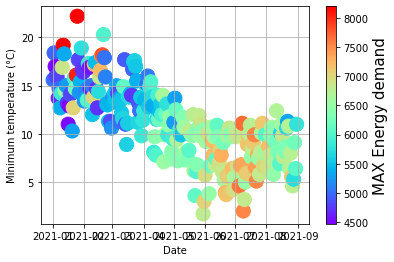

In [653]:
# Minimum temperature by Date
feature='Minimum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['TOTALDEMAND_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Energy demand", size=15)

plt.grid(True)

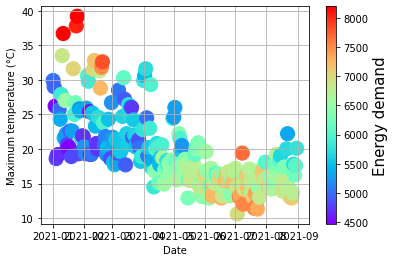

In [654]:
# Maximum temperature by Date
feature='Maximum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['TOTALDEMAND_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="Energy demand", size=15)

plt.grid(True)

## MAX Price Category

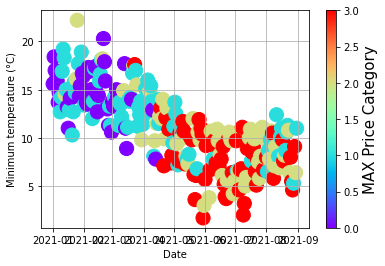

In [655]:
# Minimum temperature by Date
feature='Minimum temperature (°C)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['PRICE_NUMERIC_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Price Category", size=15)

plt.grid(True)

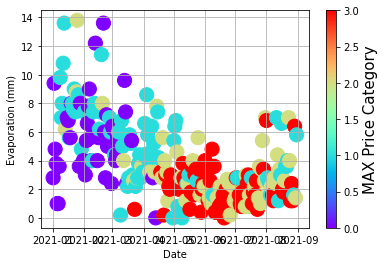

In [656]:
# Evaporation (mm) by Date
feature=\
'Evaporation (mm)'

x = dataset['Date']
plt.xlabel('Date')

y = dataset[feature]
plt.ylabel(feature)

colors = dataset['PRICE_NUMERIC_MAX']

plt.scatter(x,y,s=200, c=colors,cmap="rainbow")
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(label="MAX Price Category", size=15)

plt.grid(True)